In [109]:
from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder.appName("JobPostingsAnalysis").getOrCreate()

# Load the CSV file into a Spark DataFrame
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("/home/ubuntu/Assignment2/data/lightcast_job_postings.csv")

# Register the DataFrame as a temporary SQL view
df.createOrReplaceTempView("job_postings")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

# comment the lines below when rendering the submission
df.printSchema() 
df.show(5)

---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

In [110]:
#Industries Dimension Table
from pyspark.sql.functions import col, monotonically_increasing_id

industries_df = df.select(
    col("naics_2022_6"),
    col("naics_2022_6_name"),
    col("soc_5").alias("soc_code"),
    col("soc_5_name").alias("soc_name"),
    col("lot_specialized_occupation_name").alias("specialized_occupation"),
    col("lot_occupation_group").alias("occupation_group")
).distinct().withColumn("industry_id", monotonically_increasing_id())

# Rearrange columns to have industry_id first
industries_df = industries_df.select(
    "industry_id",
    "naics_2022_6",
    "naics_2022_6_name",
    "soc_code",
    "soc_name",
    "specialized_occupation",
    "occupation_group"
)

industries_df.show(5, truncate=False)

+-----------+------------+---------------------------------------------+--------+---------------+----------------------+----------------+
|industry_id|naics_2022_6|naics_2022_6_name                            |soc_code|soc_name       |specialized_occupation|occupation_group|
+-----------+------------+---------------------------------------------+--------+---------------+----------------------+----------------+
|0          |541613      |Marketing Consulting Services                |15-2051 |Data Scientists|SAP Analyst / Admin   |2310            |
|1          |311513      |Cheese Manufacturing                         |15-2051 |Data Scientists|Data Analyst          |2311            |
|2          |522110      |Commercial Banking                           |15-2051 |Data Scientists|SAP Analyst / Admin   |2310            |
|3          |485310      |Taxi and Ridesharing Services                |15-2051 |Data Scientists|Data Analyst          |2311            |
|4          |713990      |All Othe

In [111]:
#Companies Dimension Table
companies_df = df.select(
    col("COMPANY").alias("company_id"),
    col("COMPANY_NAME").alias("company_name"), 
    col("COMPANY_RAW").alias("company_raw"), 
    col("COMPANY_IS_STAFFING").alias("company_is_staffing")
).dropDuplicates(["company_id"]).filter(col("COMPANY").isNotNull())
# Rearrange columns to have company_id first
companies_df = companies_df.select(
    "company_id",
    "company_name",
    "company_raw",
    "company_is_staffing",
)

companies_df.show(5, truncate=False)

+----------+------------------+------------------+-------------------+
|company_id|company_name      |company_raw       |company_is_staffing|
+----------+------------------+------------------+-------------------+
|0         |Unclassified      |I20 Technologies  |false              |
|12        |Adecco            |Unknown           |true               |
|20        |Amazon            |Amazon            |false              |
|42        |Johnson & Johnson |Johnson & Johnson |false              |
|99        |UnitedHealth Group|UnitedHealth Group|false              |
+----------+------------------+------------------+-------------------+
only showing top 5 rows


In [113]:
#locations Dimension Table
from pyspark.sql.functions import col, monotonically_increasing_id

locations_df = df.select(
    col("LOCATION").alias("location_id"),
    col("CITY_NAME").alias("city_name"),
    col("STATE_NAME").alias("state_name"),
    col("COUNTY_NAME").alias("county_name"),
    col("MSA").alias("msa"),
    col("MSA_NAME").alias("msa_name"),
).filter(
    (col("LOCATION").isNotNull()) &
    (col("LOCATION") != '{"lat": 0,\n  "lon": 0\n}') & 
    (~col("CITY_NAME").like("[Unknown%")) & 
    (~col("COUNTY_NAME").like("[Unknown%"))
).dropDuplicates(["location_id"])

# Rearrange columns to have location_id first
locations_df = locations_df.select(
    "location_id",
    "city_name",
    "state_name",
    "county_name",
    "msa",
    "msa_name"
)
locations_df.show(10, truncate=False)


+-------------------------------------------------+---------------+----------+------------+-----+---------------------------+
|location_id                                      |city_name      |state_name|county_name |msa  |msa_name                   |
+-------------------------------------------------+---------------+----------+------------+-----+---------------------------+
|{\n  "lat": 19.5208333,\n  "lon": -155.9225\n}   |Kealakekua, HI |Hawaii    |Hawaii, HI  |25900|Hilo, HI                   |
|{\n  "lat": 19.639994,\n  "lon": -155.9969261\n} |Kailua-Kona, HI|Hawaii    |Hawaii, HI  |25900|Hilo, HI                   |
|{\n  "lat": 20.0230556,\n  "lon": -155.6716667\n}|Waimea, HI     |Hawaii    |Kauai, HI   |28180|Kapaa, HI                  |
|{\n  "lat": 20.7644275,\n  "lon": -156.4450063\n}|Kihei, HI      |Hawaii    |Maui, HI    |27980|Kahului-Wailuku-Lahaina, HI|
|{\n  "lat": 20.8893351,\n  "lon": -156.4729469\n}|Kahului, HI    |Hawaii    |Maui, HI    |27980|Kahului-Wailuku-Lahai

In [114]:
#Job_postings Fact Table
from pyspark.sql.functions import col, monotonically_increasing_id

job_postings_df = df.select(
    col("ID").alias("job_id"),
    col("TITLE_RAW").alias("title_raw"),
    col("TITLE_CLEAN").alias("title_clean"),
    col("COMPANY").alias("company_id"),                # FK to companies
    col("NAICS_2022_6").alias("industry_id"),          # FK to industries
    col("EMPLOYMENT_TYPE_NAME").alias("employment_type_name"),
    col("REMOTE_TYPE_NAME").alias("remote_type_name"),
    col("BODY").alias("body"),
    col("MIN_YEARS_EXPERIENCE").alias("min_years_experience"),
    col("MAX_YEARS_EXPERIENCE").alias("max_years_experience"),
    col("SALARY").alias("salary"),
    col("SALARY_FROM").alias("salary_from"),
    col("SALARY_TO").alias("salary_to"),
    col("LOCATION").alias("location_id"),              # FK to locations
    col("POSTED").alias("posted"),
    col("EXPIRED").alias("expired"),
    col("DURATION").alias("duration")
).dropDuplicates(["job_id"])


In [115]:
base_path = "/home/ubuntu/Assignment2/tables"

# Save Industries
industries_df.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .csv(f"{base_path}/industries")

# Save Companies
companies_df.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .csv(f"{base_path}/companies")

# Save Locations
locations_df.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .csv(f"{base_path}/locations")

# Save Job Postings
job_postings_df.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .csv(f"{base_path}/job_postings")

In [116]:
# Register industries table as a temp view
industries_df.createOrReplaceTempView("industries")
companies_df.createOrReplaceTempView("companies")
locations_df.createOrReplaceTempView("locations")
job_postings_df.createOrReplaceTempView("job_postings")

In [117]:
# Run a Spark SQL query to get top 5 most posted job titles
top_5_job_titles = spark.sql("""
    SELECT title_clean, COUNT(*) AS job_count
    FROM job_postings
    GROUP BY Title_clean
    ORDER BY job_count DESC
    LIMIT 5;
""")

# Show the result
top_5_job_titles.show(5, truncate=False)

+-----------------------------+---------+
|title_clean                  |job_count|
+-----------------------------+---------+
|data analyst                 |4668     |
|enterprise architect         |851      |
|senior data analyst          |785      |
|business intelligence analyst|746      |
|data modeler                 |305      |
+-----------------------------+---------+



In [118]:
top_5_job_titles_raw = spark.sql("""
    SELECT TITLE_RAW, COUNT(*) AS job_count
    FROM job_postings
    GROUP BY TITLE_RAW
    ORDER BY job_count DESC
    LIMIT 5
""")

top_5_job_titles_raw.show(5, truncate=False)

+-----------------------------+---------+
|TITLE_RAW                    |job_count|
+-----------------------------+---------+
|Data Analyst                 |4201     |
|Enterprise Architect         |808      |
|Senior Data Analyst          |724      |
|Business Intelligence Analyst|686      |
|Data Modeler                 |281      |
+-----------------------------+---------+



In [119]:
import pandas as pd

top_5_job_titles_pd = top_5_job_titles.toPandas()
top_5_job_titles_pd

,title_clean,job_count
0,data analyst,4668
1,enterprise architect,851
2,senior data analyst,785
3,business intelligence analyst,746
4,data modeler,305


In [120]:
#Query 1: Industry-Specific Salary Trends Grouped by Job Title
query1 = spark.sql("""
    SELECT 
    i.naics_2022_6_name AS industry_name,
    i.specialized_occupation,
    PERCENTILE_APPROX(j.salary, 0.5) AS median_salary
FROM job_postings j
JOIN industries i
    ON j.industry_id = i.naics_2022_6
WHERE j.salary IS NOT NULL
  AND j.salary > 0
  AND i.naics_2022_6 = '518210'
GROUP BY i.naics_2022_6_name, i.specialized_occupation
ORDER BY median_salary DESC
""")


query1.show(10, truncate=False)

+--------------------------------------------------------------------------------------+--------------------------------+-------------+
|industry_name                                                                         |specialized_occupation          |median_salary|
+--------------------------------------------------------------------------------------+--------------------------------+-------------+
|Computing Infrastructure Providers, Data Processing, Web Hosting, and Related Services|Financial Data Analyst          |134984       |
|Computing Infrastructure Providers, Data Processing, Web Hosting, and Related Services|Data Quality Analyst            |134984       |
|Computing Infrastructure Providers, Data Processing, Web Hosting, and Related Services|Marketing Analyst               |134984       |
|Computing Infrastructure Providers, Data Processing, Web Hosting, and Related Services|Data Analyst                    |134984       |
|Computing Infrastructure Providers, Data Proces

In [121]:
# Visualization using Plotly
import plotly.express as px

query1_df = query1.toPandas()

fig = px.bar(
    query1_df,
    x="median_salary",
    y="specialized_occupation",
    orientation="h",
    title="Median Salary Trends in the Technology Sector by Specialized Occupation",
    labels={"median_salary": "Median Salary ($)", "specialized_occupation": "Specialized Occupation"},
    color_discrete_sequence=["#1f77b4"] 
)

# 调整布局
fig.update_layout(
    xaxis=dict(
        title="Median Salary ($)",
        range=[0, 120000],
        dtick=20000
    ),
    yaxis_title="Specialized Occupation",
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)


fig.show()

In [122]:
# Query 2: Top 5 Companies with the Most Remote Jobs in California

query2 = spark.sql("""
    SELECT 
        c.company_name,
        COUNT(*) AS remote_jobs
    FROM job_postings j
    JOIN companies c 
        ON j.company_id = c.company_id
    JOIN locations l 
        ON j.location_id = l.location_id
    WHERE j.remote_type_name = 'Remote'
      AND l.state_name = 'California'
    GROUP BY c.company_name
    ORDER BY remote_jobs DESC
    LIMIT 5
""")

query2.show(truncate=False)

+----------------------------------------------+-----------+
|company_name                                  |remote_jobs|
+----------------------------------------------+-----------+
|Unclassified                                  |63         |
|Kaiser Permanente                             |33         |
|University of California                      |23         |
|The Judge Group                               |21         |
|California Public Employees' Retirement System|12         |
+----------------------------------------------+-----------+



In [91]:
query2_df = query2.toPandas()

/tmp/ipykernel_2359/1805866087.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




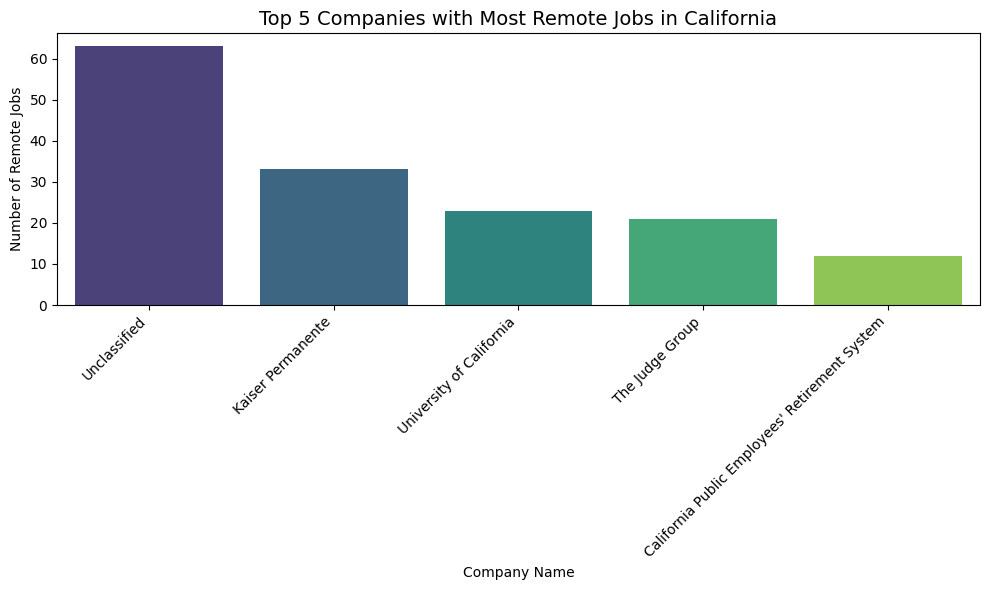

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    data=query2_df, 
    x="company_name", 
    y="remote_jobs", 
    palette="viridis"
)

plt.title("Top 5 Companies with Most Remote Jobs in California", fontsize=14)
plt.xlabel("Company Name")
plt.ylabel("Number of Remote Jobs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [93]:
# Query 3: Monthly Job Posting Trends in California
query3 = spark.sql("""
    SELECT 
        YEAR(TO_DATE(j.posted, 'M/d/yyyy')) AS year,
        MONTH(TO_DATE(j.posted, 'M/d/yyyy')) AS month,
        COUNT(*) AS job_count
    FROM job_postings j
    JOIN locations l
        ON j.location_id = l.location_id
    WHERE l.state_name = 'California'
        AND j.posted IS NOT NULL
    GROUP BY year, month
    ORDER BY year, month
""")

# 转 pandas 补齐月份
query3_pd = query3.toPandas()
query3_pd = query3_pd.set_index(['year','month']).unstack(fill_value=0).stack().reset_index()

/tmp/ipykernel_2359/1297534270.py:18: FutureWarning:                            

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



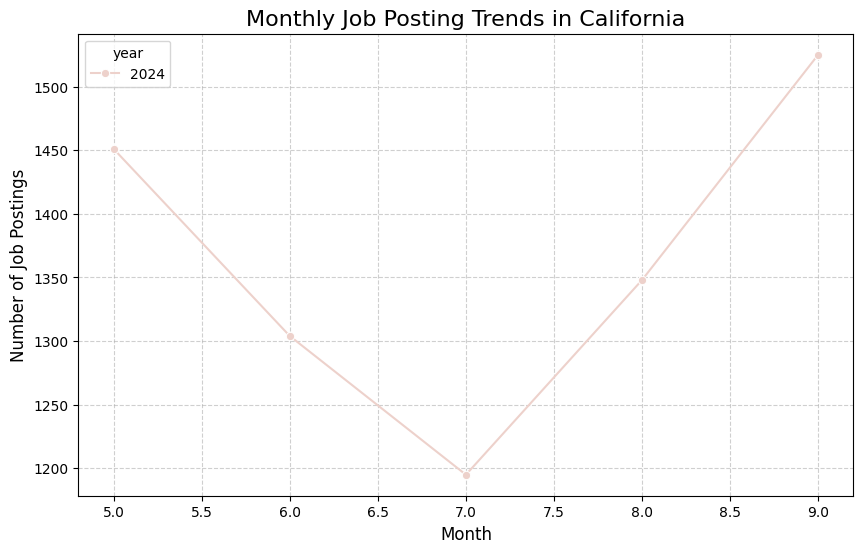

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# 确保数据按时间排序
query3_pd = query3_pd.sort_values(by=["year", "month"])

plt.figure(figsize=(10,6))
sns.lineplot(
    data=query3_pd, 
    x="month", 
    y="job_count", 
    hue="year", 
    marker="o"
)

plt.title("Monthly Job Posting Trends in California", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Job Postings", fontsize=12)

# 设置 x 轴范围和间隔
plt.xticks(ticks=[x/2 for x in range(10, 19)], labels=[x/2 for x in range(10, 19)])  
# 上面生成 [5.0, 5.5, 6.0, ..., 9.0]

plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [105]:
#Query 4: Salary Comparisons Across Major US Cities

# 注册表
job_postings_df.createOrReplaceTempView("job_postings")
locations_df.createOrReplaceTempView("locations")

query4 = spark.sql("""
    SELECT 
        CASE 
            WHEN l.msa = '14460' THEN 'Boston'
            WHEN l.msa = '47900' THEN 'Washington DC'
            WHEN l.msa = '35620' THEN 'New York'
            WHEN l.msa = '41860' THEN 'San Francisco'
            WHEN l.msa = '42660' THEN 'Seattle'
            WHEN l.msa = '31080' THEN 'Los Angeles'
            WHEN l.msa = '19100' THEN 'Dallas'
            WHEN l.msa = '26420' THEN 'Houston'
            WHEN l.msa = '12420' THEN 'Austin'
            WHEN l.msa = '34980' THEN 'Nashville'
            WHEN l.msa = '28140' THEN 'Kansas City'
            WHEN l.msa = '19740' THEN 'Denver'
        END AS metro_area,
        ROUND(AVG(j.salary), -2) AS avg_salary,   -- 四舍五入到百位
        COUNT(*) AS job_count
    FROM job_postings j
    JOIN locations l 
        ON j.location_id = l.location_id
    WHERE j.salary IS NOT NULL AND j.salary > 0
      AND l.msa IN ('14460','47900','35620','41860','42660','31080',
                    '19100','26420','12420','34980','28140','19740')
    GROUP BY metro_area
    ORDER BY avg_salary DESC
""")

query4.show(truncate=False)

+-------------+----------+---------+
|metro_area   |avg_salary|job_count|
+-------------+----------+---------+
|San Francisco|137300.0  |960      |
|Seattle      |129400.0  |692      |
|Washington DC|127400.0  |1436     |
|New York     |125400.0  |2018     |
|Boston       |124200.0  |662      |
|Austin       |122100.0  |547      |
|Kansas City  |122100.0  |272      |
|Dallas       |121100.0  |1128     |
|Houston      |116400.0  |451      |
|Nashville    |116300.0  |284      |
|Los Angeles  |113800.0  |1257     |
|Denver       |112900.0  |669      |
+-------------+----------+---------+



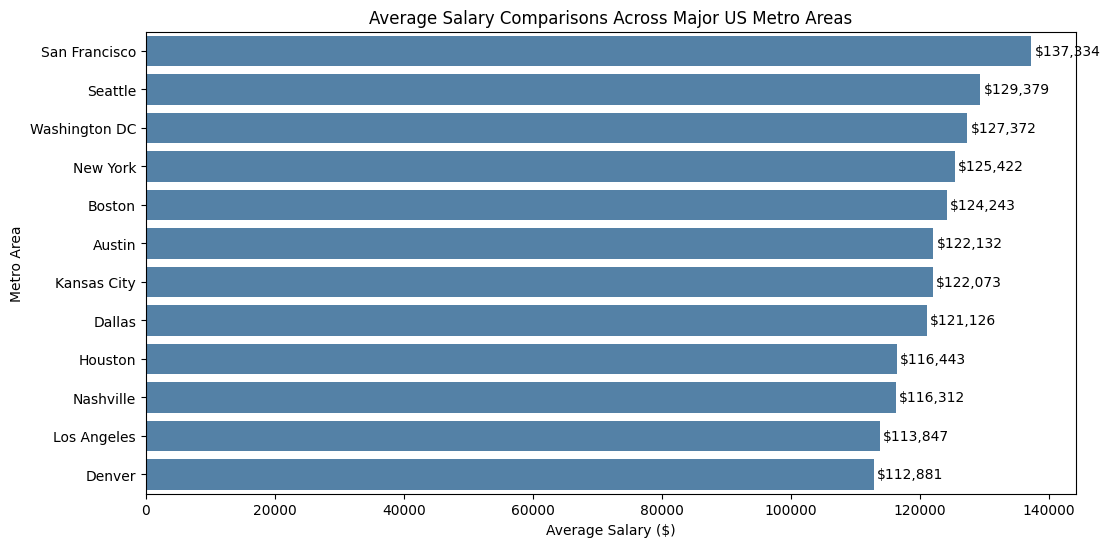

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 转 pandas
query4_df = query4.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_pd,
    y="metro_area", 
    x="avg_salary", 
    palette="Blues_r"
)

plt.title("Average Salary Comparisons Across Major US Metro Areas")
plt.xlabel("Average Salary ($)")
plt.ylabel("Metro Area")
plt.show()
